# **Ciencia de Datos para Sensores Inteligentes**
### Tarea 3: Procesamiento de audio.

En este *notebook* se explorarán cinco técnicas de Python para procesamiento de imágenes con imágenes de varias fuentes.

In [1]:
# Librerías a utilizar
import os
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
from IPython.display import display
import matplotlib.pyplot as plt
import mahotas

path = "images"

/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/mahotas/morph.py:322: SyntaxWarning: invalid escape sequence '\s'
  with ``1``\s, while the ``0``\s line up with ``0``\s (``2``\s correspond to
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/mahotas/features/texture.py:111: SyntaxWarning: invalid escape sequence '\|'
  Feature 10 (index 9) has two interpretations, as the variance of \|x-y\|
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/mahotas/features/texture.py:223: SyntaxWarning: invalid escape sequence '\|'
  Feature 10 (index 9) has two interpretations, as the variance of \|x-y\|


## OpenCV

Esta librería de visión por computadora permite la captura, procesamiento y análisis de imágenes y videos. 

Se utilizará para capturar video de la cámara web y, tras preprocesarlos, mostrar los contornos en la imagen en tiempo real. Este proceso consiste de los siguientes pasos:
1. Reescalar la imagen para acelerar el procesamiento continuo de los datos.
2. Transformar la imagen a escala de grises por medio de `cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)`.
3. Aplicar un filtro Gaussiano con `cv2.GaussianBlur` (cuyo kernel puede ajustarse con la ventana de controles) para reducir el impacto del ruido en la búsqueda de bordes.
4. Utilizar `cv2.canny()` para detectar bordes en la imagen. Los umbrales en la ventana de controles son los parámetros de esta función, permiten determinar si un píxel es un borde, así como clasificarlos en fuertes y débiles.
5. Utilizar los bordes encontrados para encontrar contornos en la imagen, con `cv2.findContours()`.

La imágenes dadas por la cámara antes de iniciar el proceso, así como las que resultan de los pasos 2, 4 y 5 se mostrarán en pantalla. 

La tecla **Esc** termina la interacción.

In [2]:
try:
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        raise RuntimeError("No fue posible acceder a la cámara web.")

    cv2.namedWindow("Controles")

    cv2.createTrackbar("Umbral de bordes débiles", "Controles", 50, 255, lambda _: None)
    cv2.createTrackbar("Umbral de bordes fuertes", "Controles", 150, 255, lambda _: None)
    cv2.createTrackbar("Kernel del filtro Gaussiano", "Controles", 1, 10, lambda _: None)

    while True:
        if cv2.waitKey(1) & 0xFF == 27:
            break

        ret, frame = cap.read()
        if not ret:
            break

        low_threshold = cv2.getTrackbarPos("Umbral de bordes débiles", "Controles")
        high_threshold = cv2.getTrackbarPos("Umbral de bordes fuertes", "Controles")
        kernel_blur = cv2.getTrackbarPos("Kernel del filtro Gaussiano", "Controles")
        kernel_blur = (2*kernel_blur + 1)

        frame_height, frame_width = frame.shape[:2]
        frame = cv2.resize(frame, (640, int(frame_height * 640 / frame_width)))

        grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred_frame = cv2.GaussianBlur(grayscale_frame, (kernel_blur, kernel_blur), 0)
        edges = cv2.Canny(blurred_frame, low_threshold, high_threshold, apertureSize=3, L2gradient=True)

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contour_frame = frame.copy()
        cv2.drawContours(contour_frame, contours, -1, (0, 255, 0), 2)

        top = np.hstack((frame, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)))
        bottom = np.hstack((blurred_frame[:, :, None].repeat(3, axis=2), contour_frame))
        display = np.vstack((top, bottom))

        cv2.imshow("Deteccion de contornos en tiempo real con OpenCV", display)

except Exception as error:
    print(f"Error: {error}")

finally:
    if 'cap' in locals():
        cap.release()
    cv2.destroyAllWindows()

QFontDatabase: Cannot find font directory /home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Tarea 5/.venv/lib64/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/ian/Documents/Grad school/Ciencia de Datos para S

## Pillow

Esta librería permite crear, cargar y guardar imágenes, así como transformaciones geométricas (redimensionar, rotar, etc.), visuales (ajuste de brillo o contraste) y aplicar filtros (escala de grises, búsqueda de bordes, relieves, etc.)

Se dibujará un cuadrado de un cierto color y dentro se incluirán varias primitivas geométricas, así como texto.

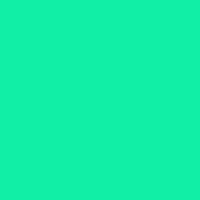

In [3]:
img = Image.new("RGB", size=(200, 200), color=(17, 239, 167))
img

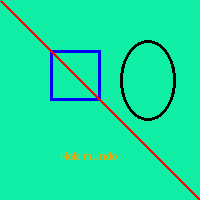

In [4]:
draw = ImageDraw.Draw(img)
draw.rectangle((50, 50, 100, 100), outline="blue", width=3)
draw.ellipse((120, 40, 175, 120), outline="black", width=3)
draw.line((0, 0, 200, 200), fill="red", width=2)
draw.text((60, 150), "Hola mundo", fill="orange")

img

A continuación se cargará una imagen y se le aplicarán varios filtros. 

Ilustración digital de Chai formato JPEG y de tamaño (1422, 2048). Se muestra una versión de tamaño (355, 512).


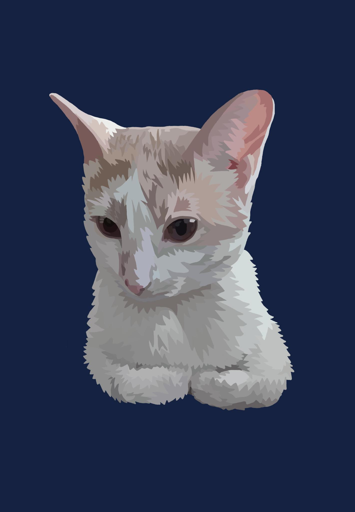

In [5]:
chai_path = os.path.join(path, "dibujo_chai.jpg")

chai = Image.open(chai_path)
width, height = chai.size
chai_small = chai.resize((width // 4, height // 4))

print(f"Ilustración digital de Chai formato {chai.format} y de tamaño {chai.size}. Se muestra una versión de tamaño {chai_small.size}.")
chai_small

Ilustración anterior tras aplicar un filtro Gaussiano, detección de bordes y relieve, respectivamente.


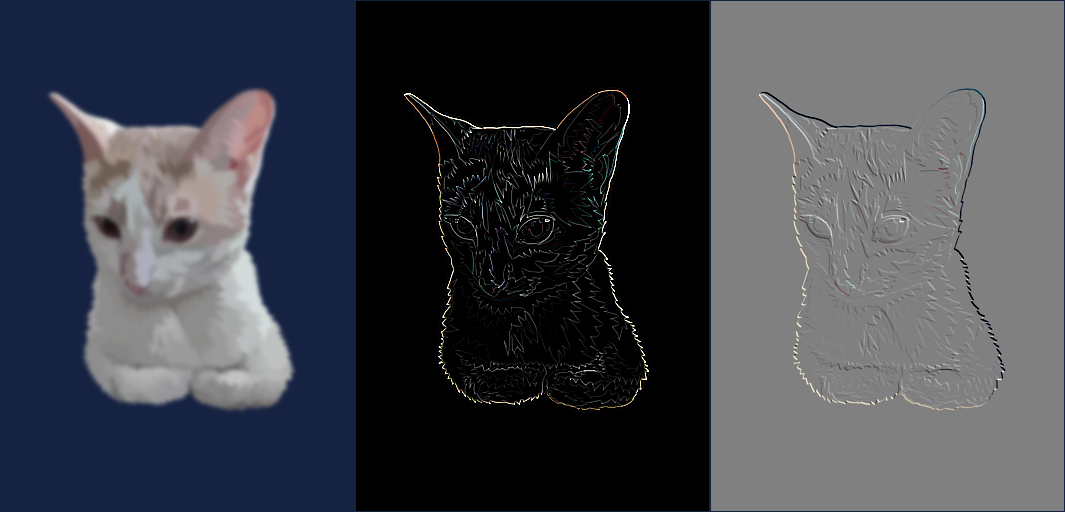

In [6]:
width_small, height_small = chai_small.size
chais = Image.new("RGB", (width_small * 3, height_small))
chais.paste(chai_small.filter(ImageFilter.GaussianBlur(radius=2)), (0, 0))
chais.paste(chai_small.filter(ImageFilter.FIND_EDGES), (width_small, 0))
chais.paste(chai_small.filter(ImageFilter.EMBOSS), (2 * width_small, 0))

print("Ilustración anterior tras aplicar un filtro Gaussiano, detección de bordes y relieve, respectivamente.")
chais

Es posible convertir imágenes de Pillow en arreglos de NumPy...

In [7]:
chai_array = np.array(chai_small)
print(f"(Altura, ancho, canales de colores) = {chai_array.shape}")

(Altura, ancho, canales de colores) = (512, 355, 3)


Manipular el arreglo directamente, y convertirlo de vuelta en una imagen de Pillow.

Ilustración convertida a escala de grises manipulando los valores de los pixeles directamente y utilizando convert('L') de Pillow, respectivamente.


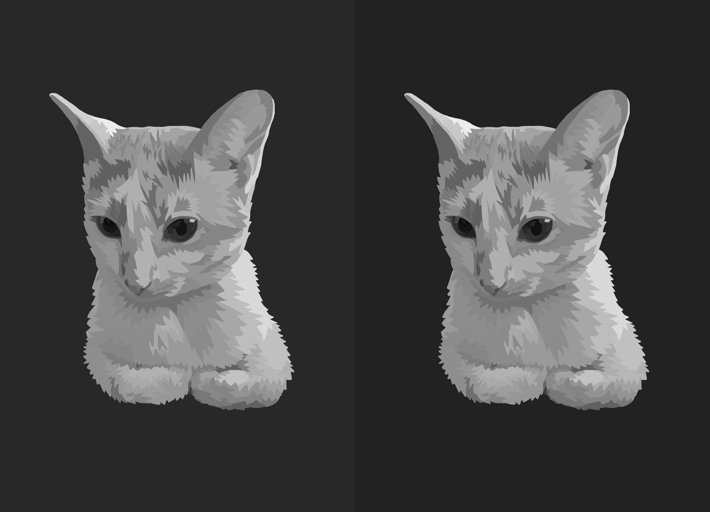

In [8]:
grayscale_array = chai_array.mean(axis=2).astype(np.uint8)
chai_grayscale_array = Image.fromarray(grayscale_array)

chai_grayscale_pillow = chai_small.convert("L")

gray_chais = Image.new("RGB", (width_small * 2, height_small))
gray_chais.paste(chai_grayscale_array.convert("RGB"), (0, 0))
gray_chais.paste(chai_grayscale_pillow.convert("RGB"), (width_small, 0))

print(f"Ilustración convertida a escala de grises manipulando los valores de los pixeles directamente y utilizando convert('L') de Pillow, respectivamente.")
gray_chais

## Mahotas

Imagen de prueba con células y versión procesada para mostrar regiones donde estas se encuentran.
Número de células detectadas: 45


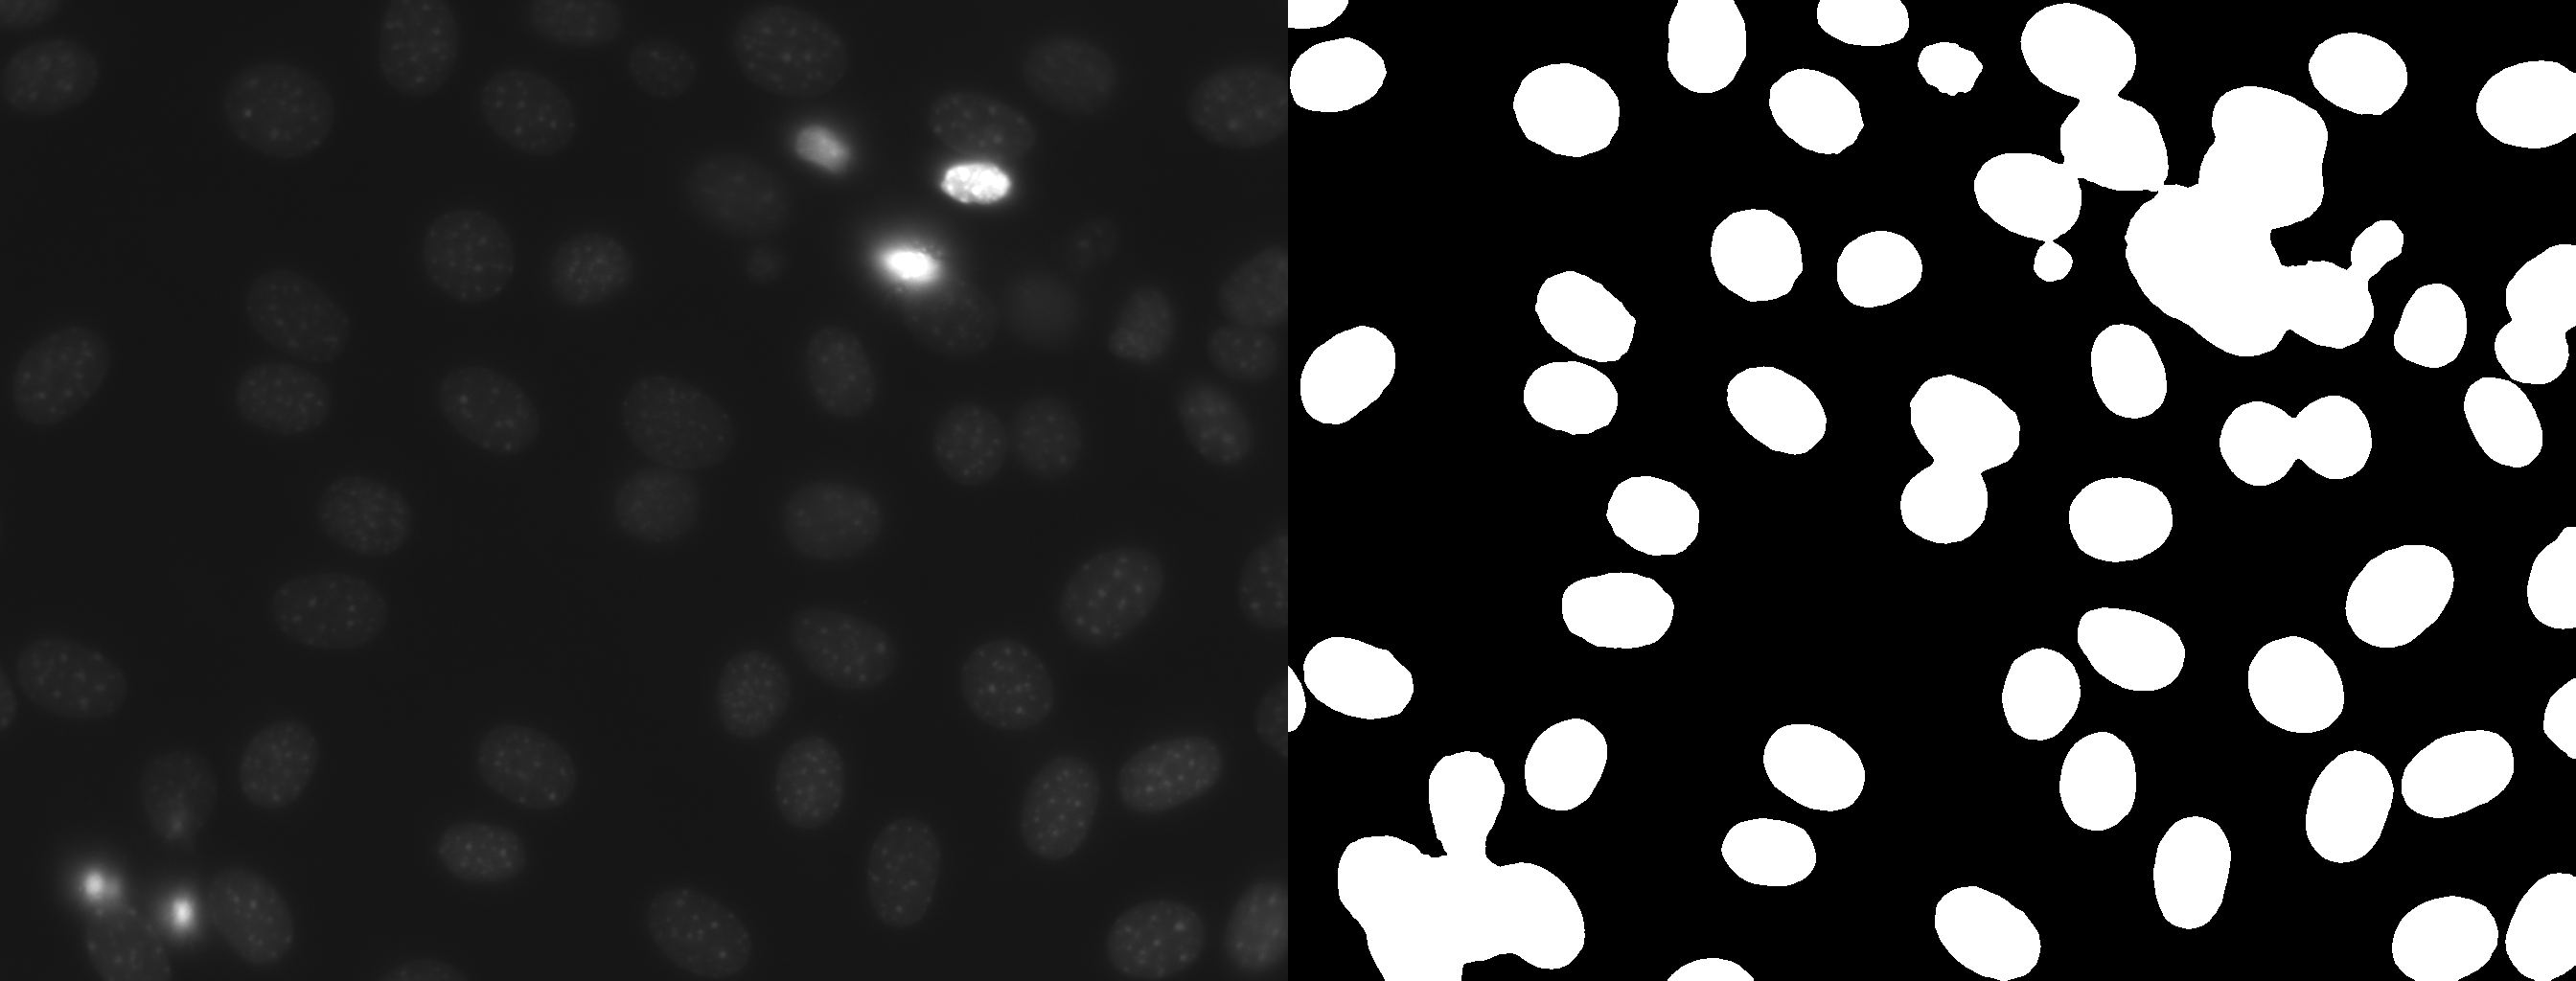

In [9]:
cells = mahotas.demos.load('nuclear')
cells = cells[:, :, 0]

cells_pil = Image.fromarray(cells)
width, height = cells_pil.size

cells = mahotas.gaussian_filter(cells, 2)
cells = (cells > cells.mean())
labelled, n_nucleus = mahotas.label(cells)

labelled_cells = Image.fromarray(cells)
cells_comparison = Image.new("RGB", (width * 2, height))
cells_comparison.paste(cells_pil.convert("RGB"), (0, 0))
cells_comparison.paste(labelled_cells.convert("RGB"), (width, 0))

print("Imagen de prueba con células y versión procesada para mostrar regiones donde estas se encuentran.") 
print(f"Número de células detectadas: {n_nucleus}")
cells_comparison